In [1]:
import numpy as np
import matplotlib.pyplot as plt
import decoding_functions as df
import random, timeit, copy

from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Flatten, LSTM
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.backend import clear_session

Using TensorFlow backend.


# Data loading and processing

In [7]:
train_files = ['moby10b.txt','dracula.txt','totc.txt','origin.txt']#,'alice.txt','pp.txt','cw.txt']
test_files = ['cw.txt']
raw_train_text=""
raw_test_text=""

for filename in train_files:
    with open('text/'+filename,'r') as file:
        raw_train_text+=file.read().replace('\n', ' ')
processed_train_text = df.alphabetize(raw_train_text)
train_text_nospace = "".join(processed_train_text.split())

for filename in test_files:
    with open('text/'+filename,'r') as file:
        raw_test_text += file.read().replace('\n', ' ')
processed_test_text = df.alphabetize(raw_test_text)
test_text_nospace = "".join(processed_test_text.split())

In [12]:
def encrypt_half_text(text_size):
    m = len(text_nospace)//text_size 
    strings =[text_nospace[text_size*(i) : text_size*(i+1)] for i in range(m)]

    return_strings = []
    keys = []
    
    for i in range(m//2): #Encrypt every other string, seeding with different values
        current_string, current_key = df.jumble(strings[2*i],i)
        return_strings.append(current_string)
        keys.append([df.char_to_n[char] for char in current_key])
        return_strings.append(strings[2*i+1])
    
    return return_strings, keys      

In [38]:
X_strings, _ = encrypt_half_text(1024)
X = np.array([df.get_threegram_frequencies(string) for string in X_strings])
X_lstm_oh = np.array([to_categorical([df.char_to_n[a] for a in string], num_classes=26) for string in X_strings])
Y = np.array(int(len(X)/2)*[0,1]).reshape((-1,1)) #Encrypted: 0, English:1

theoretical_frequencies = df.get_threegram_frequencies(text_nospace)

test_string_plain = test_text_nospace[2700:2700+1024]
test_string_encrypted, test_key = df.jumble(test_string_plain)

test_frequencies_plain = df.get_threegram_frequencies(test_string_plain)
test_frequencies_encrypted = df.get_threegram_frequencies(test_string_encrypted)

print(f'Number of training strings: {len(X_strings)}\n \n')
print(f'Test string, plain: {test_string_plain}\n \n')
print(f'Test string, encrypted: {test_string_encrypted}')

Number of training strings: 2878
 

Test string, plain: eplungedintotheswimmingtankorwenthuntingwiththejudgessonsheescortedmollieandalicethejudgesdaughtersonlongtwilightorearlymorningramblesonwintrynightshelayatthejudgesfeetbeforetheroaringlibraryfirehecarriedthejudgesgrandsonsonhisbackorrolledtheminthegrassandguardedtheirfootstepsthroughwildadventuresdowntothefountaininthestableyardandevenbeyondwherethepaddockswereandtheberrypatchesamongtheterriershestalkedimperiouslyandtootsandysabelheutterlyignoredforhewaskingkingoverallcreepingcrawlingflyingthingsofjudgemillersplacehumansincludedhisfatherelmoahugestbernardhadbeenthejudgesinseparablecompanionandbuckbidfairtofollowinthewayofhisfatherhewasnotsolargeheweighedonlyonehundredandfortypoundsforhismothershephadbeenascotchshepherddogneverthelessonehundredandfortypoundstowhichwasaddedthedignitythatcomesofgoodlivinganduniversalrespectenabledhimtocarryhimselfinrightroyalfashionduringthefouryearssincehispuppyhoodhehadlivedthelifeofasatedaristocra

# Network configuration and training

## Dense

In [17]:
def make_classifyer(units):
    classifyer_input = Input(shape=(26*26*26,))
    classifyer_dense = Dense(units,activation='relu')(classifyer_input)
    classifyer_drop = Dropout(0.4)(classifyer_dense)
    classifyer_out = Dense(1, activation='sigmoid')(classifyer_drop)

    return Model(classifyer_input, classifyer_out)

In [24]:
classifyer = make_classifyer(64)
plot_model(classifyer, show_shapes=True)
classifyer.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])
classifyer.fit(X,Y,epochs=32,validation_split=0.2, verbose=0)

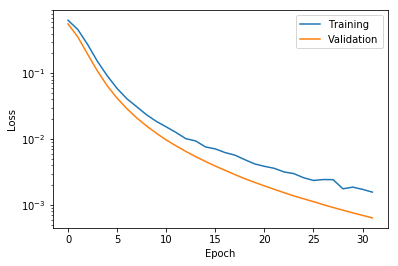

In [29]:
plt.plot(classifyer.history.history['loss'],label='Training')
plt.plot(classifyer.history.history['val_loss'],label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

In [404]:
print("Output of plaintext: ", classifyer.predict(test_frequencies_plain.reshape((1,-1)))[0,0])
print("Output of encrypted text: ", classifyer.predict(test_frequencies_encrypted.reshape((1,-1)))[0,0])

Output of plaintext:  0.99932325
Output of encrypted text:  0.0002524576


## LSTM

In [812]:
def make_lstm_classifyer(units):
    lstm_input = Input(shape=(None,26))
    lstm_layer = LSTM(units)(lstm_input)
    lstm_drop = Dropout(0.3)(lstm_layer)
    lstm_layer2 = Dense(128, activation='relu')(lstm_drop)
    lstm_out = Dense(1, activation='sigmoid')(lstm_layer2)
    
    return Model(lstm_input, lstm_out)    

In [1106]:
lstm_classifyer = make_lstm_classifyer(512)
lstm_classifyer.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_classifyer.fit(X_lstm_oh,Y,epochs=10,validation_split=0.1)

KeyboardInterrupt: 

# Decryption

In [405]:
def fitness(key, encrypted_text):
    plaintext = key.decrypt(encrypted_text)
    frequencies = np.array(df.get_threegram_frequencies(plaintext)).reshape((1,-1))
    return classifyer.predict(frequencies)[0,0]
    #return 2.-np.sum(np.abs(frequencies-theoretical_frequencies))#21.-frequencies.dot(logfreqs)[0]

In [82]:
class IndividualKey:
    
    def __init__(self, parent1=None, parent2=None, pivot_point=None):
        np.random.seed()
        if parent1 is None: parent1 = np.random.permutation(26)
        if parent2 is None: parent2 = np.random.permutation(26)
        if pivot_point is None: pivot_point = np.random.randint(25)     
        
        self.key = np.zeros(26, dtype='int')

        parent1_contribution = np.copy(parent1[:pivot_point])
        parent2_contribution = np.copy(parent2[pivot_point:])
        fillers = list(set(np.arange(26))-set(parent1_contribution)-set(parent2_contribution))
        
        for i, element in enumerate(parent2_contribution):
            if element in parent1_contribution:
                parent2_contribution[i] = fillers.pop()

        self.key[:pivot_point] = parent1_contribution
        self.key[pivot_point:] = parent2_contribution
   
    def mutate(self):
        c1, c2 = np.random.choice(26, 2, replace=False)
        self.key[c1], self.key[c2] = self.key[c2], self.key[c1]
    
    def decrypt(self, text):
        plaintext = "".join([df.n_to_char[self.key[df.char_to_n[a]]] for a in df.alphabetize(text)])
        return plaintext

## Greedy

In [101]:
def decrypt_greedy(encrypted_string, n_keys=10, n_mutations=1000):
    scores = np.zeros((n_keys, n_mutations))
    keys = []
    
    for k in range(n_keys):
        current_key = IndividualKey()
        current_fitness = fitness(current_key, encrypted_string)
           
        for i in range(n_mutations):
            candidate_key = copy.deepcopy(current_key)
            candidate_key.mutate()
            candidate_fitness = fitness(candidate_key, encrypted_string)
            
            if candidate_fitness > current_fitness:
                current_key = candidate_key
                current_fitness = candidate_fitness
     
            scores[k, i] = current_fitness
        print(f"Key {k+1} of {n_keys}. Fitness: {current_fitness:.2}")
        keys.append(current_key)
       
    return scores, keys

In [106]:
scores, keys = decrypt_greedy(test_string_encrypted,n_keys=5,n_mutations=2000)

Key 1 of 5. Fitness: 0.34
Key 2 of 5. Fitness: 0.35
Key 3 of 5. Fitness: 0.8
Key 4 of 5. Fitness: 0.36
Key 5 of 5. Fitness: 0.36


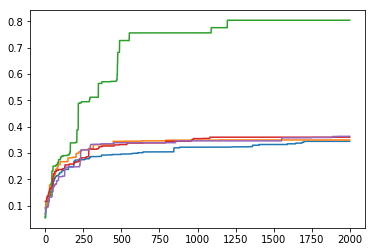

In [109]:
for i in range(5): plt.plot(scores[i])

## Genetic

In [406]:
def run_genetics(n_keys=32, n_generations=1501, mutation_rate=0.01, crossover_rate=0.9, verbose=True):
    population = []
    fitnesses = np.zeros(n_keys)

    best_fitnesses = []

    encrypted_text = test_string_encrypted

    for i in range(n_keys):
        population.append(IndividualKey())
        fitnesses[i]=fitness(population[-1], encrypted_text)
        #print(population[i].key)
    for generation in range(n_generations):
        children = []
        child_fitnesses = []

        #Make and process enough children
        for i in range(n_keys//2):

            pivot_point = np.random.randint(25)

            #Selection: pick parents
            if np.sum(fitnesses)>0:
                weights = fitnesses
                weights = weights/np.sum(weights)
                parent1, parent2 = np.random.choice(population, 2, replace=False, p=weights)
            else:
                parent1, parent2 = np.random.choice(population, 2, replace=False)



            #Crossover: Decide if parents reproduce over or not
            if np.random.choice([True, False], p=[crossover_rate, 1-crossover_rate]):
                child1 = IndividualKey(parent1.key, parent2.key, pivot_point=pivot_point)
                child2 = IndividualKey(parent2.key, parent1.key, pivot_point=pivot_point)
            else:
                child1 = copy.deepcopy(parent1)
                child2 = copy.deepcopy(parent2)


            #Mutation: keep mutation if beneficial
            if np.random.choice([True, False],p=[mutation_rate, 1-mutation_rate]): 
                child1_clone = copy.deepcopy(child1)
                child1_clone.mutate()
                if fitness(child1_clone, encrypted_text) >= fitness(child1, encrypted_text):
                    child1 = copy.deepcopy(child1_clone)

            if np.random.choice([True, False],p=[mutation_rate, 1-mutation_rate]):
                child2_clone = copy.deepcopy(child2)
                child2_clone.mutate()
                if fitness(child2_clone, encrypted_text) >= fitness(child2, encrypted_text):
                    child2 = copy.deepcopy(child2_clone)


            children.append(child1)
            children.append(child2)

            child_fitnesses.append(fitness(child1, encrypted_text))
            child_fitnesses.append(fitness(child2, encrypted_text))

            #Move onto new generation
        population = children
        fitnesses = child_fitnesses

        best_fitnesses.append(np.max(fitnesses))

        if generation%100==0 and verbose==True:
            print(f"Generation {generation}, Average fitness: {np.mean(fitnesses):.2e}, Best fitness: {np.max(fitnesses):.2e}, Test accuracy: {string_accuracy(population[np.argmax(fitnesses)].decrypt(encrypted_text),test_string)[0]:.2e}")
    return best_fitnesses, population

In [304]:
parameters = np.zeros((500,3))

In [305]:
for i in range(500):
    parameters[i,0] = 16+int(2**(0.5*np.random.randint(2,11)))
    parameters[i,1] = np.random.random()
    parameters[i,2] = np.random.random()

In [407]:
runs = np.zeros((500,1001,3))
for i, rate in enumerate(parameters):
    for k in range(3):
       # print(int(rate[0]), rate[1], rate[2])
        run, _ = run_genetics(n_generations=1001, n_keys=int(rate[0]), mutation_rate=rate[1], crossover_rate=rate[2], verbose=False)
        runs[i,:,k] = run
                                                                                   
    print(f"Rate {i+1} of {len(rates)}")

Rate 1 of 500
Rate 2 of 500
Rate 3 of 500
Rate 4 of 500
Rate 5 of 500
Rate 6 of 500
Rate 7 of 500
Rate 8 of 500
Rate 9 of 500
Rate 10 of 500
Rate 11 of 500
Rate 12 of 500
Rate 13 of 500
Rate 14 of 500
Rate 15 of 500
Rate 16 of 500
Rate 17 of 500
Rate 18 of 500
Rate 19 of 500
Rate 20 of 500
Rate 21 of 500
Rate 22 of 500
Rate 23 of 500
Rate 24 of 500
Rate 25 of 500
Rate 26 of 500
Rate 27 of 500
Rate 28 of 500
Rate 29 of 500
Rate 30 of 500
Rate 31 of 500
Rate 32 of 500
Rate 33 of 500
Rate 34 of 500
Rate 35 of 500
Rate 36 of 500
Rate 37 of 500
Rate 38 of 500
Rate 39 of 500
Rate 40 of 500
Rate 41 of 500
Rate 42 of 500
Rate 43 of 500
Rate 44 of 500
Rate 45 of 500
Rate 46 of 500
Rate 47 of 500
Rate 48 of 500
Rate 49 of 500
Rate 50 of 500
Rate 51 of 500
Rate 52 of 500
Rate 53 of 500
Rate 54 of 500
Rate 55 of 500
Rate 56 of 500
Rate 57 of 500
Rate 58 of 500
Rate 59 of 500
Rate 60 of 500
Rate 61 of 500
Rate 62 of 500
Rate 63 of 500
Rate 64 of 500
Rate 65 of 500
Rate 66 of 500
Rate 67 of 500
Rate

In [408]:
np.save('nn_cost_run_results.npy', runs)
np.save('nn_cost_run_parameters.npy', parameters)

In [409]:
final_score_averages_nn = np.mean(runs[:,-1,:], axis=-1)
final_scores_unrolled_nn = np.concatenate((runs[:,-1,0],runs[:,-1,1],runs[:,-1,2]))
scores_unrolled_nn = np.concatenate((runs[:,:,0],runs[:,:,1],runs[:,:,2]),axis=0)
parameters_unrolled_nn = np.concatenate((parameters, parameters, parameters))

Correlation coefficient:0.10115175813362608


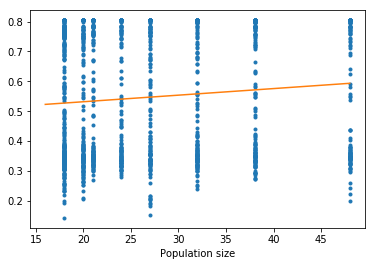

In [410]:
fit_params = np.polyfit(parameters_unrolled[:,0], final_scores_unrolled,1)
plt.plot(parameters_unrolled[:,0], final_scores_unrolled,'.')
plt.plot(np.arange(16,49), fit_params[0]*np.arange(16,49)+fit_params[1])
plt.xlabel('Population size')
print(f'Correlation coefficient:{np.corrcoef(parameters_unrolled[:,0], final_scores_unrolled)[1,0]}')

Correlation coefficient:-0.08827367899985433


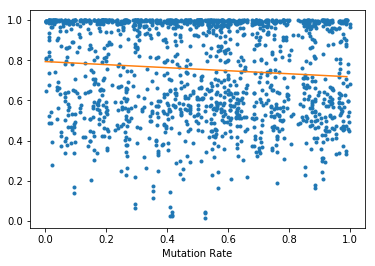

In [415]:
fit_params_nn = np.polyfit(parameters_unrolled_nn[:,2], final_scores_unrolled_nn,1)
plt.plot(parameters_unrolled_nn[:,2], final_scores_unrolled_nn,'.')
plt.plot(np.arange(0,100)/100., fit_params_nn[0]*np.arange(0,100.)/100.+fit_params_nn[1])
plt.xlabel('Mutation Rate')
print(f'Correlation coefficient:{np.corrcoef(parameters_unrolled_nn[:,2], final_scores_unrolled_nn)[1,0]}')

Correlation coefficient:0.45570520049036506


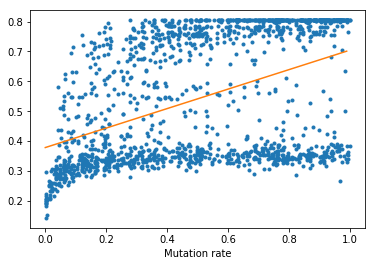

In [339]:
fit_params = np.polyfit(parameters_unrolled[:,1], final_scores_unrolled,1)
plt.plot(parameters_unrolled[:,1], final_scores_unrolled,'.')
plt.plot(np.arange(0,100)/100., fit_params[0]*np.arange(0,100)/100.+fit_params[1])
plt.xlabel('Mutation rate')
print(f'Correlation coefficient:{np.corrcoef(parameters_unrolled[:,1], final_scores_unrolled)[1,0]}')

Correlation coefficient:-0.03659010167426408


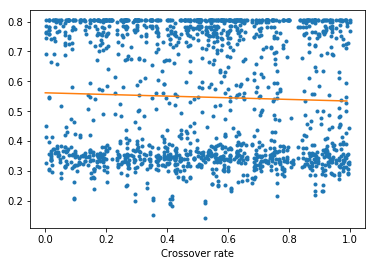

In [340]:
fit_params = np.polyfit(parameters_unrolled[:,2], final_scores_unrolled,1)
plt.plot(parameters_unrolled[:,2], final_scores_unrolled,'.')
plt.plot(np.arange(0,100)/100., fit_params[0]*np.arange(0,100)/100.+fit_params[1])
plt.xlabel('Crossover rate')
print(f'Correlation coefficient:{np.corrcoef(parameters_unrolled[:,2], final_scores_unrolled)[1,0]}')

In [391]:
good_params = parameters_unrolled[finish_times<1000]
bad_params = parameters_unrolled[finish_times>=1000]

(array([0.8548285 , 0.93679835, 0.83140854, 0.91337839, 1.18270792,
        1.135868  , 1.135868  , 1.07731811, 0.78456862, 1.20612788]),
 array([0.00160768, 0.1010224 , 0.20043713, 0.29985185, 0.39926657,
        0.49868129, 0.59809602, 0.69751074, 0.79692546, 0.89634018,
        0.99575491]),
 <a list of 10 Patch objects>)

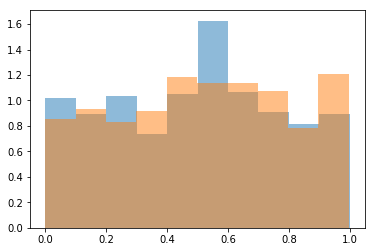

In [394]:
plt.hist(good_params[:,2],density=True, alpha=0.5)
plt.hist(bad_params[:,2], density=True, alpha=0.5)

(array([231.,  87.,  65.,  75.,  84.,   0.,  83.,   0.,   0.,  97.]),
 array([18., 21., 24., 27., 30., 33., 36., 39., 42., 45., 48.]),
 <a list of 10 Patch objects>)

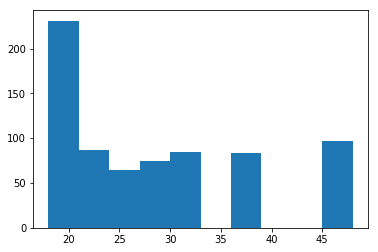

In [351]:
plt.hist(bad_params[:,0])

In [448]:
finish_score = 0.95*np.max(final_scores_unrolled_nn)

In [452]:
finish_times_nn = []
for score_list in scores_unrolled_nn:
    for i, score in enumerate(score_list):
        if score > finish_score:
            finish_times_nn.append(i)
            break
        if i>=1000:
            finish_times_nn.append(1000)
finish_times_nn = np.array(finish_times_nn)

In [453]:
finish_times

array([ 574, 1000,  903, ...,  836,  644,  972])

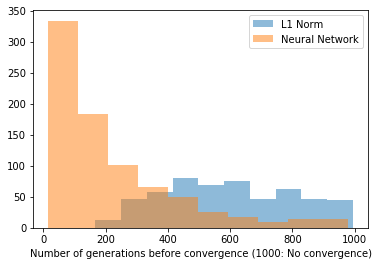

In [460]:
plt.hist(finish_times[finish_times<999],density=False, alpha=0.5, label = 'L1 Norm')
plt.hist(finish_times_nn[finish_times_nn<999], density=False, alpha=0.5, label = 'Neural Network')
plt.xlabel('Number of generations before convergence (1000: No convergence)')
plt.legend()